<a href="https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-click execution of Dreambooth Stable Diffusion
- Dec 25, 2023 - Fixed bug not saving model if folder not exist.
- Dec 24, 2023 - Updated sampler to Euler to remove warning.
- Dec 21, 2023 - Updated diffusers to the current version.
- Dec 14, 2023 - Fixed bitsandbytes import error.


Tutorials and prompts at [stable-diffusion-art.com](https://stable-diffusion-art.com)

The latest copy can be found [here](https://colab.research.google.com/github/sagiodev/stablediffusion_webui/blob/master/DreamBooth_Stable_Diffusion_SDA.ipynb).


See the [Dreambooth tutorial](https://stable-diffusion-art.com/dreambooth/) for a step-by-step guide. Leave comment under article if you have any questions.



Mounted at /content/drive
Tesla V100-SXM2-16GB, 16384 MiB, 16151 MiB


Saving tmp_zl8akzy.png to tmp_zl8akzy.png
Saving tmp6sw6gphs.png to tmp6sw6gphs.png
Saving tmp1in627ro.png to tmp1in627ro.png
Saving tmp0f5qc42h.png to tmp0f5qc42h.png
Saving tmpf1dmosnu.png to tmpf1dmosnu.png
Saving tmpn8by9_t9.png to tmpn8by9_t9.png
Saving tmpunpnu50d.png to tmpunpnu50d.png
Saving tmpwbj_1apt.png to tmpwbj_1apt.png
Saving tmp7vinve45.png to tmp7vinve45.png
Saving tmpl3pl07x8.png to tmpl3pl07x8.png
Saving tmpvttw0n35.png to tmpvttw0n35.png
Saving tmps5im4d34.png to tmps5im4d34.png
Saving tmp7gdt2c3k.png to tmp7gdt2c3k.png
Cloning into 'diffusers'...
remote: Enumerating objects: 36685, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 36685 (delta 71), reused 63 (delta 25), pack-reused 36557
Receiving objects: 100% (36685/36685), 28.54 MiB | 33.24 MiB/s, done.
Resolving deltas: 100% (27281/27281), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting r

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

[*] Converted ckpt saved at /content/drive/MyDrive/AI_PICS11111/models/my_dreambooth_model.safetensors
Dreambooth completed successfully. It took 9.0 minutes.


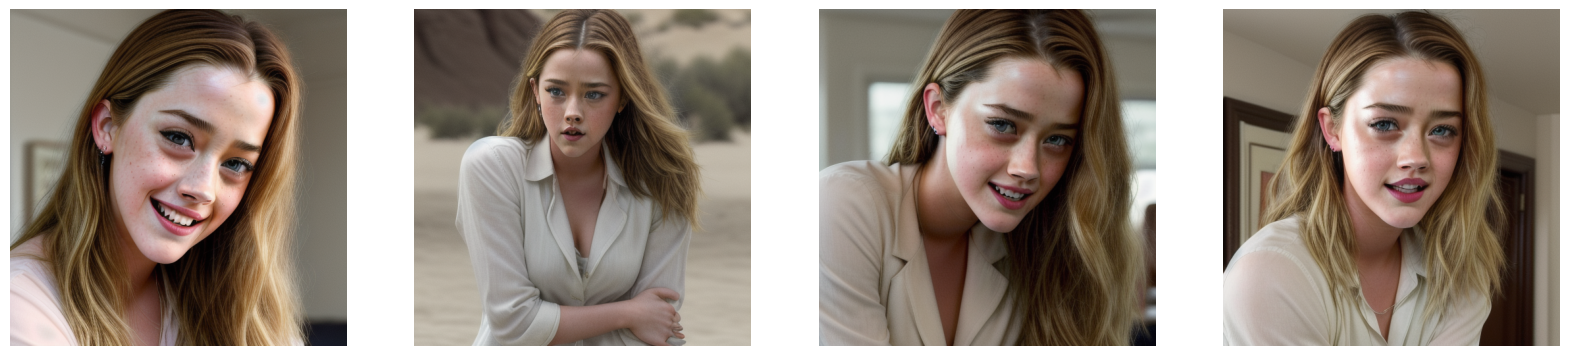

In [1]:
import time

#@title DreamBooth
HUGGINGFACE_TOKEN = ""

#@markdown Name/Path of the initial model. (Find model name [here](https://huggingface.co/models))
MODEL_NAME = "SG161222/Realistic_Vision_V2.0" #@param {type:"string"}
BRANCH = "main" #@param {type:"string"}

#@markdown Enter instance prompt and class prompt.\
#@markdown Example 1: photo of zwx person, photo of a person\
#@markdown Example 2: photo of zwx toy, photo of a toy
instance_prompt = "photo of a zwx woman" #@param {type:"string"}
class_prompt =  "photo of a woman" #@param {type:"string"}
training_steps = 400 #@param {type:"integer"}
learning_rate = 5e-6 #@param {type:"number"}
output_file = "AI_PICS/models/my_dreambooth_model.safetensors" #@param {type:"string"}
#@markdown  Convert to fp16? (takes half the space (2GB)).
fp16 = True #@param {type: "boolean"}

#@markdown Clear log after run?
CLEAR_LOG = False #@param {type:"boolean"}

# Mount google drive for saving the model
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/output"
INSTANCE_DIR = "/content/data/instance"
CLASS_DIR = "/content/data/class"
!mkdir -p $INSTANCE_DIR
!mkdir -p $CLASS_DIR

!rm -rf $OUTPUT_DIR
!mkdir -p $OUTPUT_DIR

if 'pipe' in locals():
  del pipe

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Upload training images.
import os
from google.colab import files
import shutil
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

time_start = time.time()
def clear():
    from IPython.display import clear_output; return clear_output()

# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install diffusers
!git clone https://github.com/sagiodev/diffusers.git #https://github.com/huggingface/diffusers.git
%cd diffusers
!git checkout 08b453e3828f80027d881bb460716af95e192bcd -- ./scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install .


# install dreambooth
%cd /content/diffusers/examples/dreambooth
%pip install -r requirements.txt
%pip install bitsandbytes #xformers torch==2.1.0+cu121 # gradio natsort safetensors xformers torch==2.1.0+cu121 accelerate
!accelerate config default


# test bitsandbytes
import bitsandbytes
import torch
print(torch.__version__)

# Dreambooth training - Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --revision=$BRANCH \
  --instance_prompt="$instance_prompt" \
  --class_prompt="$class_prompt" \
  --class_data_dir=$CLASS_DIR \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps

#  --enable_xformers_memory_efficient_attention \

########################################
#prompt = "photo of zwx"
prompt = instance_prompt
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np



if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None




g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    fig=figure(figsize=(5*num_samples,5*num_samples))
    for i in range(num_samples):
        a=fig.add_subplot(1, num_samples,i+1)
        imshow(images[i])
        axis('off')


######################################
# Save to checkpoint file
ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
!mkdir -p $dirname
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

In [2]:
dirname

'/content/drive/MyDrive/AI_PICS11111/models'

/content


  0%|          | 0/25 [00:00<?, ?it/s]

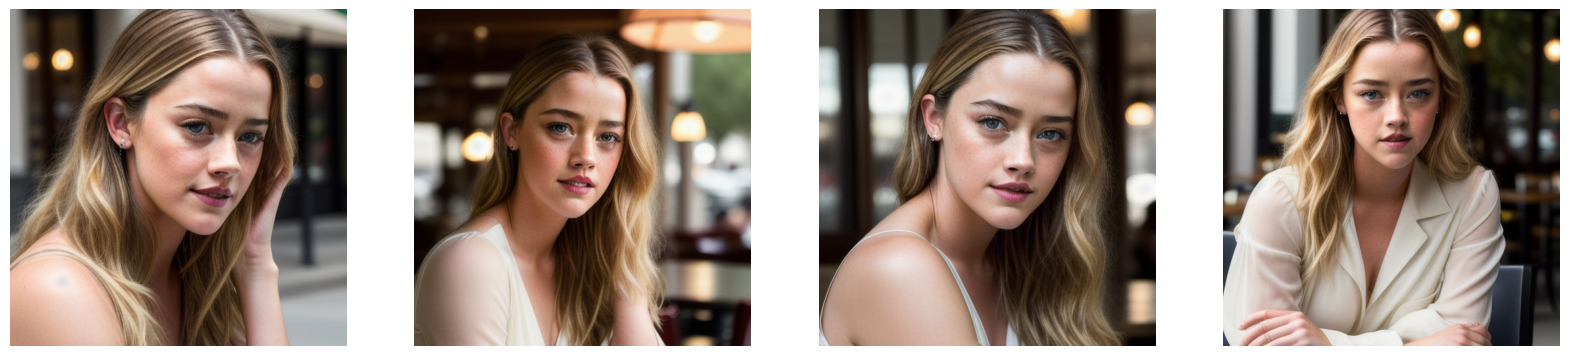

In [ ]:
#@title Test image generation from model

prompt = "Photo of zwx woman, sitting outside restaurant, wearing dress, rim lighting, studio lighting, looking at the camera, dslr, ultra quality, sharp focus, tack sharp, dof, film grain, Fujifilm XT3, crystal clear, 8K UHD, highly detailed glossy eyes, high detailed skin, skin pores" #@param {type:"string"}
negative_prompt = "disfigured, ugly, bad, immature, cartoon, anime, 3d, painting, b&w" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 25 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}
seed = 100 #@param {type:"number"}

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    fig=figure(figsize=(5*num_samples,5*num_samples))
    for i in range(num_samples):
        a=fig.add_subplot(1, num_samples,i+1)
        imshow(images[i])
        axis('off')
